c:\anaconda3\envs\ml-project-env-10\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


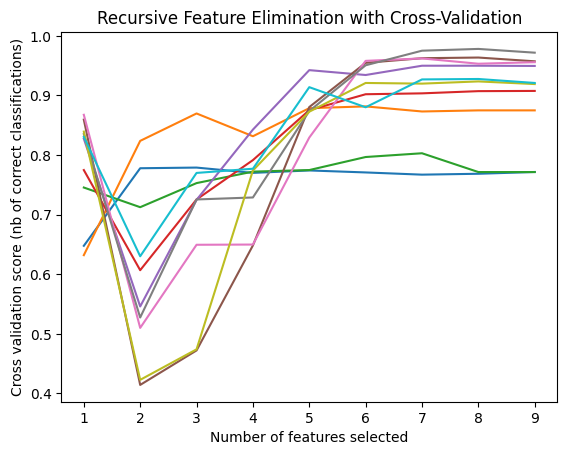

Selected features: Index(['model_year', 'cylinders_', 'fuelconsumption_city(l/100km)',
       'fuelconsumption_hwy(l/100km)', 'co2emissions_(g/km)',
       'number_of_gears', 'fuelconsumption_comb(mpg)'],
      dtype='object')


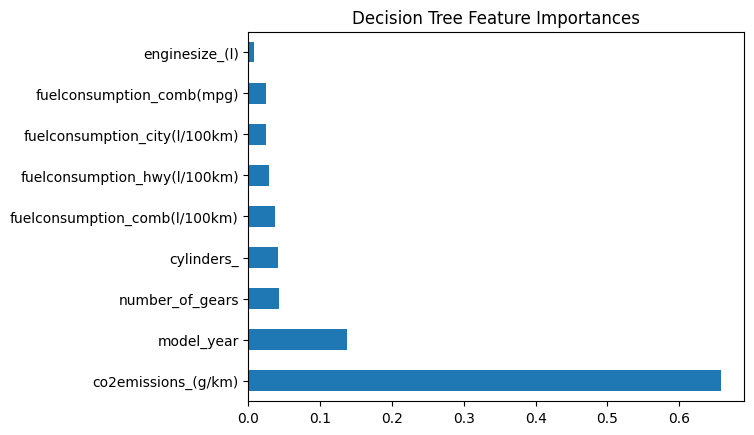

Top features: ['model_year', 'cylinders_', 'fuelconsumption_comb(l/100km)', 'co2emissions_(g/km)', 'number_of_gears']
Epoch 1/50
674/674 [==============================] - 2s 2ms/step - loss: -1560.5336 - accuracy: 0.0824 - val_loss: -8104.2388 - val_accuracy: 0.0910
Epoch 2/50
674/674 [==============================] - 1s 1ms/step - loss: -49968.7891 - accuracy: 0.0838 - val_loss: -123263.2734 - val_accuracy: 0.0985
Epoch 3/50
674/674 [==============================] - 1s 1ms/step - loss: -298010.0312 - accuracy: 0.0941 - val_loss: -531843.1875 - val_accuracy: 0.1081
Epoch 4/50
674/674 [==============================] - 1s 1ms/step - loss: -935396.2500 - accuracy: 0.1001 - val_loss: -1415646.3750 - val_accuracy: 0.1081
Epoch 5/50
674/674 [==============================] - 1s 1ms/step - loss: -2147469.7500 - accuracy: 0.1035 - val_loss: -2959730.7500 - val_accuracy: 0.1114
Epoch 6/50
674/674 [==============================] - 1s 1ms/step - loss: -4121249.7500 - accuracy: 0.1044 - val_l

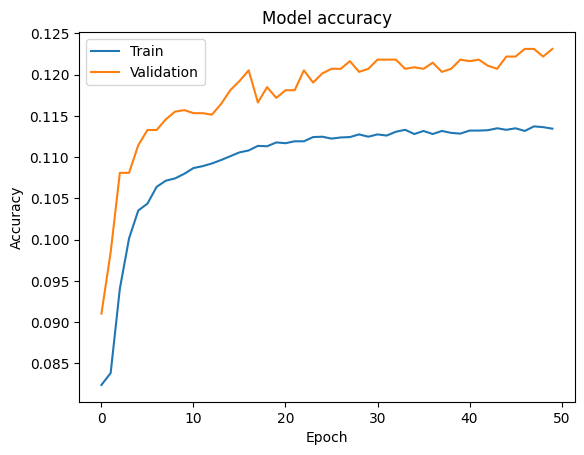

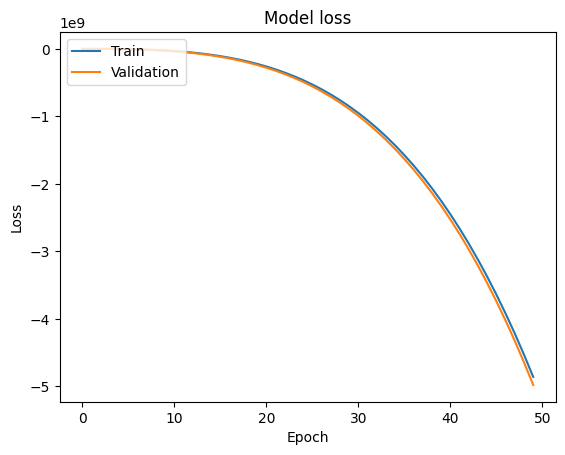

In [4]:
import pandas as pd
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os
from pathlib import Path


sys.path.append(os.path.abspath(os.path.join('..','./data/', './clean-data/')))
sys.path.append(os.path.abspath(os.path.join('..','./scripts/')))


# Load the dataset into a pandas DataFrame
df = pd.read_csv(Path("../data/predicted-data/","predicted_co2_rating.csv"))

# Select only the columns with numerical data
num_cols = df.select_dtypes(include=np.number).columns
df_num = df[num_cols]

# Perform recursive feature elimination to select the most important features
X = df_num.drop(["predicted_co2_rating",'original_co2r','id'], axis=1)
y = df_num["predicted_co2_rating"]

dt = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=dt, cv=10)
rfecv.fit(X, y)

# Plot the number of features vs. cross-validation scores
plt.figure()
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# Print the most important features
print("Selected features:", X.columns[rfecv.support_])

# Fit a decision tree and get feature importances
dt.fit(X, y)
feat_importances = pd.Series(dt.feature_importances_, index=X.columns)

# Plot the feature importances
plt.figure()
plt.title('Decision Tree Feature Importances')
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Select the top 5 most important features
threshold = feat_importances.nlargest(5).min()
top_features = feat_importances[feat_importances >= threshold].index.tolist()
print("Top features:", top_features)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[top_features])

# Encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential()
model.add(Dense(16, input_dim=len(top_features), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# Visualize the loss and accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
